In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

# 1) read_csv

In [2]:
train_x_df = pd.read_csv('./data/train_x_df.csv')
train_y_df = pd.read_csv('./data/train_y_df.csv')
test_x_df = pd.read_csv('./data/test_x_df.csv')
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


# 2) numpy arrary로 변환하기

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = len(df_2d.columns[3:])
    time_size = len(df_2d.time.unique())
    sample_size = len(df_2d.sample_id.unique())
    array_3d = df_2d.iloc[:,3:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [4]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [5]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7661, 1380, 9)
train_y_array (7661, 120, 9)
test_x_array (535, 1380, 9)



# 3) 샘플 확인하기

In [6]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

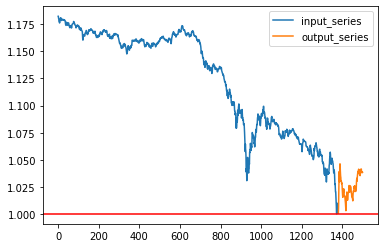

In [7]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

In [8]:
X = train_x_array[:, :, [1]]
y = train_y_array[:, :, [1]]
X.shape, y.shape

((7661, 1380, 1), (7661, 120, 1))

# train_y에서 max값과 max인 시점 구하기

In [9]:
y.shape[0]

7661

In [10]:
y_max_price = []
y_max_time = []

for i in range(y.shape[0]):
    y_max_price.append(y[i].max())
    y_max_time.append(y[i].argmax())

In [11]:
y_max_price = np.array(y_max_price)
y_max_time = np.array(y_max_time)

y_max_price.shape, y_max_time.shape 

((7661,), (7661,))

# 가장 높은 시점 그래프로 확인하기

In [12]:
def max_plot_series(x_series, y_series, y_max_value, y_max_time):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.scatter(len(x_series)+y_max_time, y_max_value, c = 'green', label = 'max_time')
    plt.axhline(1, c = 'red')
    plt.legend()

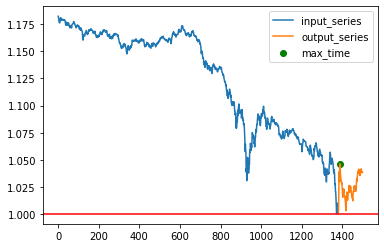

In [13]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
max_plot_series(X[idx], y[idx], y_max_price[idx], y_max_time[idx])
plt.show()

# train 데이터 분할하여 결과 확인해보기

In [14]:
X = X.reshape(X.shape[0], X.shape[1]) 
y = y.reshape(y.shape[0], y.shape[1]) 

In [15]:
X_train, X_test, Y_train, Y_test, y_price_train, y_price_test, y_time_train, y_time_test = train_test_split(X, y, y_max_price, y_max_time, test_size=0.2, random_state=529)
X_train.shape, Y_train.shape, y_price_train.shape, y_time_train.shape

((6128, 1380), (6128, 120), (6128,), (6128,))

# max_time 예측

In [16]:
lgbm_time = LGBMRegressor()
lgbm_time.fit(X_train, y_time_train)

LGBMRegressor()

In [17]:
y_time_pred = lgbm_time.predict(X_test)

# max_value 예측

In [18]:
lgbm_price = LGBMRegressor()
lgbm_price.fit(X_train, y_price_train)

LGBMRegressor()

In [19]:
y_price_pred = lgbm_price.predict(X_test)

# 예측 결과 시각화

In [20]:
def pred_plot_series(x_series, y_series, y_max_value, y_max_time, y_value_pred, y_time_pred):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.scatter(len(x_series)+y_max_time, y_max_value, c = 'green', label = 'max_time')
    plt.scatter(len(x_series)+y_time_pred, y_value_pred, c = 'red', label = 'pred_max')
    plt.axhline(1, c = 'red')
    plt.legend()

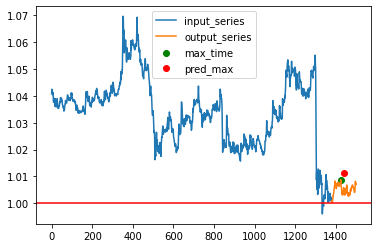

In [21]:
idx = 12
pred_plot_series(X_test[idx], Y_test[idx], y_price_test[idx], y_time_test[idx], y_price_pred[idx], y_time_pred[idx])
plt.show()

# Kfold

time은 mse, price는 mae를 활용

# max_time 예측

In [22]:
def time_kfold(model, train_x, train_y, test, n_folds=10):
    
    folds = KFold(n_splits=n_folds, shuffle=False)
    sub = np.zeros((test.shape[0], 1))
    outcomes=[]

    for n_fold, (train_index, valid_index) in enumerate(folds.split(train_x)):
        
        X_train, X_val = train_x[train_index], train_x[valid_index]
        y_train, y_val = train_y[train_index], train_y[valid_index]
        
        #학습
        model.fit(X_train, y_train)
        
        # val 데이터 예측
        y_val = np.array(y_val).reshape(-1, 1)
        y_val_predict = model.predict(X_val).reshape(-1, 1)
        
        mse_val = mse(y_val, y_val_predict)
        outcomes.append(mse_val)
        
        # 테스트 데이터 예측
        sub += model.predict(test).reshape(-1, 1)
        
    # val mse값으로 성능 평가
    print(np.mean(outcomes))
    test_pred = sub/(folds.n_splits)
    
    return test_pred

In [23]:
model = LGBMRegressor()
test_time_pred = time_kfold(model, X_train, y_time_train, X_test)

35.84054733162939


# max_price 예측

In [24]:
def price_kfold(model, train_x, train_y, test, n_folds=10):
    
    folds = KFold(n_splits=n_folds, shuffle=False)
    sub = np.zeros((test.shape[0], 1))
    outcomes=[]

    for n_fold, (train_index, valid_index) in enumerate(folds.split(train_x)):
        
        X_train, X_val = train_x[train_index], train_x[valid_index]
        y_train, y_val = train_y[train_index], train_y[valid_index]
        
        #학습
        model.fit(X_train, y_train)
        
        # val 데이터 예측
        y_val = np.array(y_val).reshape(-1, 1)
        y_val_predict = model.predict(X_val).reshape(-1, 1)
        
        mae_val = mae(y_val, y_val_predict)
        outcomes.append(mae_val)
        
        # 테스트 데이터 예측
        sub += model.predict(test).reshape(-1, 1)
        
    # val mae값으로 성능 평가
    print(np.mean(outcomes))
    test_pred = sub/(folds.n_splits)
    
    return test_pred

In [25]:
model = LGBMRegressor()
test_price_pred = price_kfold(model, X_train, y_price_train, X_test)

0.00823250403872502


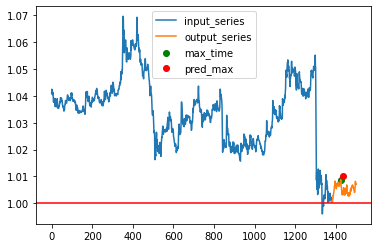

In [26]:
idx = 12
pred_plot_series(X_test[idx], Y_test[idx], y_price_test[idx], y_time_test[idx], test_price_pred[idx], test_time_pred[idx])
plt.show()

# 테스트 셋 적용

In [27]:
test = test_x_array[:, :, [1]]
test.shape

(535, 1380, 1)

In [28]:
test = test.reshape(test.shape[0], test.shape[1]) 
test.shape

(535, 1380)

# test max_time 예측

In [29]:
model = LGBMRegressor()
test_time_pred = time_kfold(model, X, y_max_time, test)

35.78508558331725


# test max_price 예측

In [30]:
model = LGBMRegressor()
test_price_pred = price_kfold(model, X, y_max_price, test)

0.00807821508761127


# 제출 파일 생성

최대 값인 time int로 변경

In [31]:
test_time_pred[0][0]

45.91774645177898

In [32]:
sell_time = []

for i in range(len(test_time_pred)):
    sell_time.append(int(round(test_time_pred[i][0])))
    

최대 값 매수 범위 설정

In [33]:
buy_quantity = np.where(test_price_pred > 1.015, 1, 0)

In [34]:
submission = pd.read_csv('./data/sample_submission.csv')
submission 

,sample_id,buy_quantity,sell_time
0,7661,0,0
1,7662,0,0
2,7663,0,0
3,7664,0,0
4,7665,0,0
...,...,...,...
530,8191,0,0
531,8192,0,0
532,8193,0,0
533,8194,0,0


In [35]:
submission['sell_time'] = sell_time
submission

,sample_id,buy_quantity,sell_time
0,7661,0,46
1,7662,0,57
2,7663,0,50
3,7664,0,59
4,7665,0,45
...,...,...,...
530,8191,0,57
531,8192,0,55
532,8193,0,43
533,8194,0,52


In [36]:
submission['buy_quantity'] = buy_quantity
submission

,sample_id,buy_quantity,sell_time
0,7661,1,46
1,7662,1,57
2,7663,1,50
3,7664,1,59
4,7665,1,45
...,...,...,...
530,8191,1,57
531,8192,0,55
532,8193,1,43
533,8194,0,52


In [37]:
submission.buy_quantity.value_counts() 

0    315
1    220
Name: buy_quantity, dtype: int64

In [38]:
submission.to_csv('./submission_lgbm_re_1.015.csv', index = False)